<a href="https://colab.research.google.com/github/mpfoster/Biochem5721/blob/master/Intro_fitting_kinetics_5721_au23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to data fitting in Python for Biochem 5721
This notebook is intended as a tutorial for introducing students to data fitting in Python via some useful guides and examples.

For an interactive experience, after loading into a Jupyter environment, clear all output using `Edit > Clear all outputs`, then progress through the notebook executing one code cell at a time. Some code cells may need to be edited depending on your data location.

2023-11-02 MPF/DBW

## Data fitting with Python, using Matplotlib and Pandas
We will start with data for the first-order decomposition of penicillin during storage at 25°C. The data can be loaded from a file, or entered as lists of $x$ and $y$ values. This notebook illustrates reading the values from a _.csv_ (comma separated values) file, and speciying the data in a code cell.

We will read in the data using the `pandas` package, https://pandas.pydata.org/. Pandas simplifies loading tabular data into a `DataFrame`, which is a special type of table with rows and columns like we would have in Excel, but now able to be efficiently programatically manipulated using Python. For this example, we will load a `.csv` (comma-separated-values) file that looks like this:
```
Time_weeks,Penicillin_U
0.0,10100
1.0,8180
2.0,6900
3.0,5380
4.0,4320
5.0,3870
7.0,2190
8.0,2000
9.0,1790
10.0,1330
11.0,1040
12.0,898
13.0,750
14.0,572
15.0,403
16.0,403
17.0,314
18.0,279
19.0,181
20.0,167
```
The first row has column labels; the rest are data. We can drag/drop the file into the Jupyter Files sidebar, and tell Pandas to load the data in the file into a data frame. [(See Pandas docs for more.)](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_table.html)

In [1]:
# use pandas to load the data from a local file
import pandas as pd
datafile = 'https://github.com/mpfoster/Biochem5721/raw/master/Data/penicillin-data.csv' # Either local files or web addresses can be loaded
df = pd.read_csv(datafile) # here, assumes file in current directory
df  # show the contents of the data frame

,Time_weeks,Penicillin_U
0,0.0,10100
1,1.0,8180
2,2.0,6900
3,3.0,5380
4,4.0,4320
5,5.0,3870
6,7.0,2190
7,8.0,2000
8,9.0,1790
9,10.0,1330


In [2]:
# Alternatively, uncomment the following to define the data here

#import numpy as np
#import pandas as pd
#xdata = np.array([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0])
#ydata = np.array([10100, 8180, 6900, 5380, 4320, 3870, 2190, 2000, 1790, 1330, 1040, 898, 750, 572, 403, 403, 314, 279, 181, 167])
#d = {'Time_weeks': xdata, 'Penicillin_U': ydata}
#df = pd.DataFrame(data=d)
#df

# ^^^
# It is not required to use a pandas df, but there are benefits, and the
# rest of the tutorial assumes we've placed our data in one.
# We could have just defined our xdata and ydata and proceeded

In [3]:
# read the data from the df into variables
xdata = df['Time_weeks']
ydata = df['Penicillin_U']

and... plot the data:

Text(0, 0.5, 'Penicillin Units')

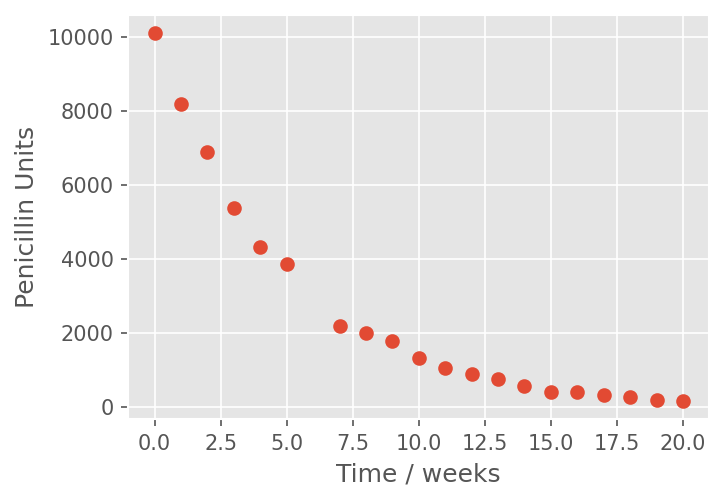

In [4]:
import matplotlib.pyplot as plt
plt.style.use('ggplot') # one of many available plot styles
fig,ax = plt.subplots( figsize=(5,3.5), dpi=150 ) # Configure figure size and resolution in dots per inch (dpi)
ax.plot(xdata, ydata, 'o') # plot the data using a scatter plot
ax.set_xlabel('Time / weeks')
ax.set_ylabel('Penicillin Units')

## Fitting to a model
We've hypothesized that the data can be described by a first-order kinetic process, whose integrated form is:

$$[A]=[A_0]e^{-kt}$$

where $[A_0]$ the value of $[A]$ at time $t = 0$, and $k$ is the first order rate constant. We see from the data that $[A_0]= 1.01e4$. Our goal is to find a value of $k$ that best explains the data.

We will write out the integrated rate equation in a form that Python will understand. We will do this in the form of a _function_, so we can call and re-use the function by name; e.g., the square root function `sqrt()`.

In [5]:
# We define functions for integrated kinetic rate laws

import numpy as np

def decay_1p(x,k):
  # one-parameter exponential decay, with rate constant k
  return np.exp(-k*x)

def decay_2p(x,k,A):
  # two-parameter exponential decay, with amplitude A
  return A*np.exp(-x*k)

def decay_3p(x,k,A,C):
  # three-parameter exponential decay, rate const k, amplitude A and offset C
  return A*np.exp(-x*k) + C

def biphasic(x,k1,A1,k2,A2): # two rate constants, two amplitudes
  return A1*np.exp(-x*k1)+A2*np.exp(-x*k2)

def biphasic_offset(x,k1,A1,k2,A2,C): # two rate constants, two amplitudes + C
  return A1*np.exp(-x*k1)+A2*np.exp(-x*k2)+C

def sec_order_1(t,a0,k): # 2a -> c
    return a0/(a0*k*t+1)

def sec_order_2(t,a0,b0,k): # a + b -> c
    return a0*b0*(np.exp(k*t*(a0 - b0)) - 1)/(a0*np.exp(k*t*(a0 - b0)) - b0)

Having defined a function, we need to define/guess some initial parameters for the model, then plot the model along with the data to see how well it agrees.

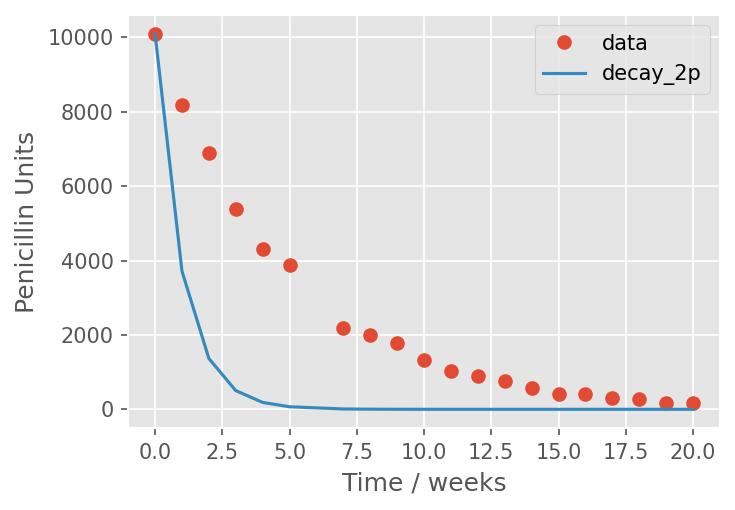

In [6]:
func = decay_2p
a0=1.01e4 # activity at t=0
k = 1 # 1 is often a good starting point for an unknown
p0 = (k,a0)
# calculate y values using our model parameters:
calc_y = func(xdata, *p0) # 1st-order decay y = a0*exp(-k*x)
# now plot the data and calculated values against the same x values:

fig,ax = plt.subplots(figsize=(5,3.5), dpi=150)
ax.plot(xdata, ydata, 'o', label='data') # plot the data using a scatter plot
ax.plot(xdata, calc_y, label=f'{func.__name__}')
ax.set_xlabel('Time / weeks')
ax.set_ylabel('Penicillin Units')

ax.legend()
fig.tight_layout()

We evaluate the goodness of fit by computing a chi-square ($\chi^2$), the squared sum of the residual differences between the data ($y$ values) and the model evaluated at each $x$ value, $f(x)$:
$$\chi^2 =  \sum_i\left(y(x)-f(x)\right)^2 = \sum_i (residuals)^2$$


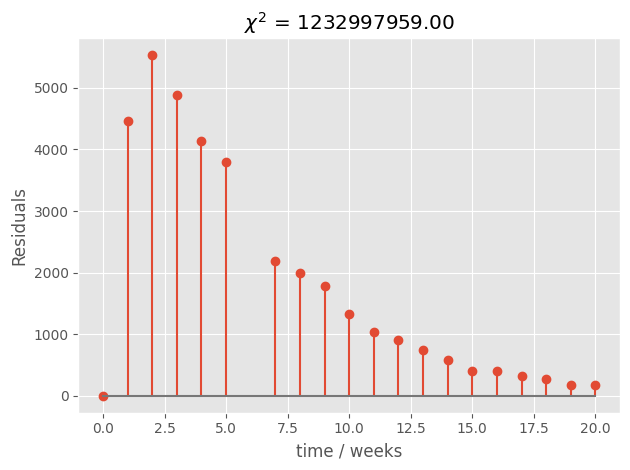

In [7]:
residuals = ydata - calc_y
fig,ax = plt.subplots()
ax.stem(xdata,residuals)
ax.set_xlabel('time / weeks')
ax.set_ylabel('Residuals')
ax.set_title('$\chi^2$ = %.2f' % (sum(residuals))**2 )

fig.tight_layout()

*Fitting* involves finding model parameters that minimize the difference between the data and the model. Because an exponential decay equation  is not a straight line, we call this non-linear curve fitting.

There are many algorithms and packages for curve fitting; here we use Scipy curve_fit:

Optimized parameters: [2.03622120e-01 1.00997015e+04]
Covariance matrix: [[7.31093451e-06 1.37719688e-01]
 [1.37719688e-01 6.72599479e+03]]


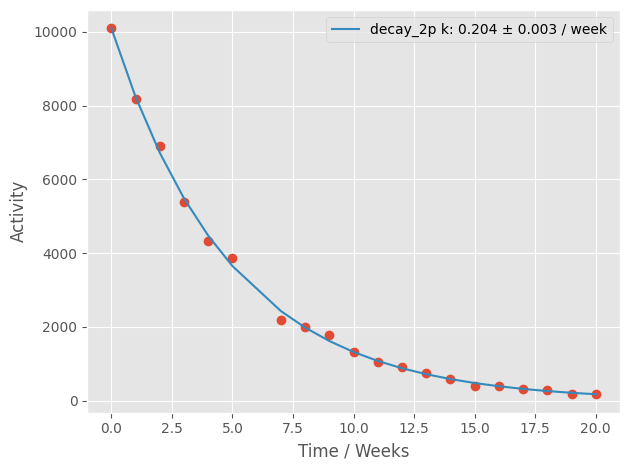

In [8]:
from scipy.optimize import curve_fit
'''
<function: scipy.optimize.minpack.curve_fit(f, xdata, ydata, p0=None, sigma=None, absolute_sigma=False,
    check_finite=True, bounds=(-inf, inf), method=None, jac=None, **kwargs)>

for scipy's curve_fit function: we need to at least provide the function f, and x and y data.
we could provide initial parameters via the list p0
'''
# specify the function to be used to generate model data
func = decay_2p # y = a0*exp(-k*x)
xdata = df['Time_weeks']
ydata = df['Penicillin_U']
p0 = (1.0,1e4) # optionally, provide starting parameters
# run, and return parameter best-fit and covariation:
popt,pcov = curve_fit(func,xdata,ydata, p0 = p0)
print("Optimized parameters:", popt)
print("Covariance matrix:", pcov)
# Compute Standard errors:
perr = np.sqrt(np.diag(pcov)) # square root of matrix diagonal
# Always, always, visualize the fit before the trusting parameters:
calc_data = func(xdata,*popt) # evaluate the function f with the optimized params

fig, ax = plt.subplots()
ax.plot(xdata,ydata,'o')
ax.plot(xdata,calc_data, label=f'{func.__name__} k: {popt[0]:.3f} ± {perr[0]:.3f} / week')
ax.set_xlabel('Time / Weeks')
ax.set_ylabel('Activity')
ax.legend()

fig.tight_layout()

When we are satisfied with the agreement between model and data, we have found the _best-fit parameters of the model_.

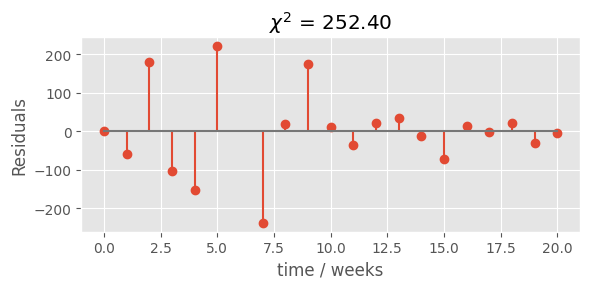

In [9]:
residuals = ydata - calc_data
fig,ax = plt.subplots(figsize=(6,3))
ax.stem(xdata,residuals)
ax.set_xlabel('time / weeks'); ax.set_ylabel('Residuals')
ax.set_title('$\chi^2$ = %.2f' % (sum(residuals))**2 )
fig.tight_layout()

In [10]:
print(f'Best-fit: {popt}')
# Standard deviation estimate:
perr = np.sqrt(np.diag(pcov))
print(f'Standard Error: {perr}')

Best-fit: [2.03622120e-01 1.00997015e+04]
Standard Error: [2.70387398e-03 8.20121625e+01]


If desired, we can append to the dataframe the initial values, best-fit, and residuals of the fit:

In [11]:
#df['init'] = result.init_fit
df['best'] = calc_data
df['residuals'] = residuals
df.head()
# export df to a new csv file
#df.to_csv('output.csv')

,Time_weeks,Penicillin_U,best,residuals
0,0.0,10100,10099.701500,0.298500
1,1.0,8180,8239.039310,-59.039310
2,2.0,6900,6721.165844,178.834156
3,3.0,5380,5482.929332,-102.929332
4,4.0,4320,4472.812420,-152.812420


<Axes: xlabel='Time_weeks'>

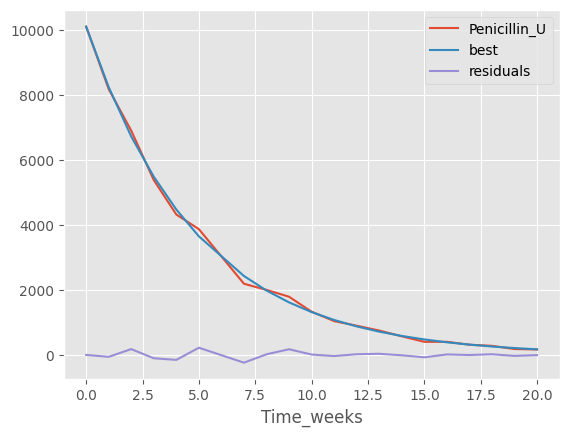

In [12]:
# shortcut to plotting data in the df (if created)
df.plot(x='Time_weeks', y=['Penicillin_U','best','residuals'])